# Import all the required packages

In [77]:
import numpy as np
import os 
import scipy
import sklearn
import boto3
from botocore.handlers import disable_signing
import pandas as pd 
from scipy.fft import fft,fftfreq
from scipy.fftpack import fftshift
from scipy.signal import spectrogram
import nilearn 
from nilearn import image, plotting
import matplotlib as plt
from matplotlib import pyplot as plt
from nilearn.masking import apply_mask
import nibabel as nb
from scipy.signal import freqz



# Extract resting-state images of the selected subject 


### Loading Resting-State images found on AOMIC for ind 0001

In [78]:
# Create a client
client = boto3.client('s3')
# Disable the signing in requirements to use S3 bucket
client.meta.events.register('choose-signer.s3.*', disable_signing)
# Create a reusable Paginator
paginator = client.get_paginator('list_objects')
# Select the desired dataset from the AOMIC S3 bucket
operation_parameters = {'Bucket' : 'openneuro.org', 'Prefix' : 'ds002785/derivatives/fmriprep/sub-0001'}
result = paginator.paginate(**operation_parameters)
# Create a PageIterator from the Paginator 
filtered_iterator = result.search("Contents[?Key.contains(@,'task-restingstate')]")
task_list=[key_data['Key'] for key_data in filtered_iterator]
# Print the filtered results
print(task_list)





['ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-bbregister_bold.svg', 'ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-carpetplot_bold.svg', 'ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-compcorvar_bold.svg', 'ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-confoundcorr_bold.svg', 'ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-rois_bold.svg', 'ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-sdc_bold.svg', 'ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.json', 'ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.tsv', 'ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_boldref.nii.gz', 'd

### Reorganize the filtered results

In [79]:
# Make an np array from task list
files = np.array(task_list)
print(files)


['ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-bbregister_bold.svg'
 'ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-carpetplot_bold.svg'
 'ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-compcorvar_bold.svg'
 'ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-confoundcorr_bold.svg'
 'ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-rois_bold.svg'
 'ds002785/derivatives/fmriprep/sub-0001/figures/sub-0001_task-restingstate_acq-mb3_desc-sdc_bold.svg'
 'ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.json'
 'ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.tsv'
 'ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_boldref.nii.gz'
 'd

In [80]:
# split the filenames with the "/" character  
separator = '/'
filename_split = [filename.split(separator) for filename in files]
print(filename_split)

[['ds002785', 'derivatives', 'fmriprep', 'sub-0001', 'figures', 'sub-0001_task-restingstate_acq-mb3_desc-bbregister_bold.svg'], ['ds002785', 'derivatives', 'fmriprep', 'sub-0001', 'figures', 'sub-0001_task-restingstate_acq-mb3_desc-carpetplot_bold.svg'], ['ds002785', 'derivatives', 'fmriprep', 'sub-0001', 'figures', 'sub-0001_task-restingstate_acq-mb3_desc-compcorvar_bold.svg'], ['ds002785', 'derivatives', 'fmriprep', 'sub-0001', 'figures', 'sub-0001_task-restingstate_acq-mb3_desc-confoundcorr_bold.svg'], ['ds002785', 'derivatives', 'fmriprep', 'sub-0001', 'figures', 'sub-0001_task-restingstate_acq-mb3_desc-rois_bold.svg'], ['ds002785', 'derivatives', 'fmriprep', 'sub-0001', 'figures', 'sub-0001_task-restingstate_acq-mb3_desc-sdc_bold.svg'], ['ds002785', 'derivatives', 'fmriprep', 'sub-0001', 'func', 'sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.json'], ['ds002785', 'derivatives', 'fmriprep', 'sub-0001', 'func', 'sub-0001_task-restingstate_acq-mb3_desc-confounds_regress

In [81]:
# Cast last object as pd.dataFrame to get it 
pd_filename_list = pd.DataFrame(filename_split)
pd_filename_list = pd_filename_list[5]
print(pd_filename_list)

0     sub-0001_task-restingstate_acq-mb3_desc-bbregi...
1     sub-0001_task-restingstate_acq-mb3_desc-carpet...
2     sub-0001_task-restingstate_acq-mb3_desc-compco...
3     sub-0001_task-restingstate_acq-mb3_desc-confou...
4     sub-0001_task-restingstate_acq-mb3_desc-rois_b...
5     sub-0001_task-restingstate_acq-mb3_desc-sdc_bo...
6     sub-0001_task-restingstate_acq-mb3_desc-confou...
7     sub-0001_task-restingstate_acq-mb3_desc-confou...
8     sub-0001_task-restingstate_acq-mb3_space-MNI15...
9     sub-0001_task-restingstate_acq-mb3_space-MNI15...
10    sub-0001_task-restingstate_acq-mb3_space-MNI15...
11    sub-0001_task-restingstate_acq-mb3_space-MNI15...
12    sub-0001_task-restingstate_acq-mb3_space-MNI15...
13    sub-0001_task-restingstate_acq-mb3_space-MNI15...
14    sub-0001_task-restingstate_acq-mb3_space-MNI15...
15    sub-0001_task-restingstate_acq-mb3_space-T1w_b...
16    sub-0001_task-restingstate_acq-mb3_space-T1w_d...
17    sub-0001_task-restingstate_acq-mb3_space-T

In [82]:
# make a dataframe by splitting the filenames with the "_" character and print it
separator2 = "_"
split_filenames_2 = [filename.split(separator2) for filename in files]
pd_filename_list_2 = pd.DataFrame(data=(split_filenames_2))
print (pd_filename_list_2)

                                                    0                  1  \
0   ds002785/derivatives/fmriprep/sub-0001/figures...  task-restingstate   
1   ds002785/derivatives/fmriprep/sub-0001/figures...  task-restingstate   
2   ds002785/derivatives/fmriprep/sub-0001/figures...  task-restingstate   
3   ds002785/derivatives/fmriprep/sub-0001/figures...  task-restingstate   
4   ds002785/derivatives/fmriprep/sub-0001/figures...  task-restingstate   
5   ds002785/derivatives/fmriprep/sub-0001/figures...  task-restingstate   
6   ds002785/derivatives/fmriprep/sub-0001/func/su...  task-restingstate   
7   ds002785/derivatives/fmriprep/sub-0001/func/su...  task-restingstate   
8   ds002785/derivatives/fmriprep/sub-0001/func/su...  task-restingstate   
9   ds002785/derivatives/fmriprep/sub-0001/func/su...  task-restingstate   
10  ds002785/derivatives/fmriprep/sub-0001/func/su...  task-restingstate   
11  ds002785/derivatives/fmriprep/sub-0001/func/su...  task-restingstate   
12  ds002785

In [83]:
# select all the "nii.gz" files
nii_task_1 = pd_filename_list_2[4].str.endswith('nii.gz')
nii_task_2 = pd_filename_list_2[5].str.endswith('nii.gz')
# make an np.array of the selected filenames
df = pd_filename_list_2
filenames = []
for i in range (len(df)):
    name = df.loc[i][4]
    if name is not None and name.endswith('nii.gz'):
        filenames.append(name)
    name = df.loc[i][5]
    if name is not None and name.endswith('nii.gz'):
        filenames.append(name)
np.array(filenames)
print(filenames)

    
     
    

['boldref.nii.gz', 'dseg.nii.gz', 'dseg.nii.gz', 'mask.nii.gz', 'bold.nii.gz', 'boldref.nii.gz', 'dseg.nii.gz', 'dseg.nii.gz', 'mask.nii.gz', 'bold.nii.gz']


In [84]:
# Create a pd Data Frame with all the "nii.gz" files
nii_files = pd.DataFrame(filenames)
print(nii_files)

                0
0  boldref.nii.gz
1     dseg.nii.gz
2     dseg.nii.gz
3     mask.nii.gz
4     bold.nii.gz
5  boldref.nii.gz
6     dseg.nii.gz
7     dseg.nii.gz
8     mask.nii.gz
9     bold.nii.gz


In [85]:
# make a panda dataframe by splitting the filenames with the "_" character and print it
nii_task=np.array([x.endswith('nii.gz') for x in task_list]) 
nii_files=np.asarray(task_list)[nii_task]
pd.DataFrame([y.split("_") for y in pd.DataFrame([x.split("/") for x in  nii_files])[5] ])

0                  1        2                          3  \
0  sub-0001  task-restingstate  acq-mb3  space-MNI152NLin2009cAsym   
1  sub-0001  task-restingstate  acq-mb3  space-MNI152NLin2009cAsym   
2  sub-0001  task-restingstate  acq-mb3  space-MNI152NLin2009cAsym   
3  sub-0001  task-restingstate  acq-mb3  space-MNI152NLin2009cAsym   
4  sub-0001  task-restingstate  acq-mb3  space-MNI152NLin2009cAsym   
5  sub-0001  task-restingstate  acq-mb3                  space-T1w   
6  sub-0001  task-restingstate  acq-mb3                  space-T1w   
7  sub-0001  task-restingstate  acq-mb3                  space-T1w   
8  sub-0001  task-restingstate  acq-mb3                  space-T1w   
9  sub-0001  task-restingstate  acq-mb3                  space-T1w   

                4            5  
0  boldref.nii.gz         None  
1  desc-aparcaseg  dseg.nii.gz  
2       desc-aseg  dseg.nii.gz  
3      desc-brain  mask.nii.gz  
4    desc-preproc  bold.nii.gz  
5  boldref.nii.gz         None  
6  desc-aparcaseg  dseg.nii.gz  
7       desc-aseg  dseg.nii.gz  
8      desc-brain  mask.nii.gz  
9    desc-preproc  bold.nii.gz

In [86]:
# choose the preprocessed "nii.gz" BOLD signal resting-state images in nii_list 
file_key = nii_files[4] 
print(file_key)

ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


### Downloading the preprocessed "nii.gz" BOLD signal resting-state images for the selected subject

In [87]:
# use the boto3 client to download the file
# save it to "resting.nii.gz"
final_name = 'resting.nii.gz'
bucket_name = 'openneuro.org'
client.download_file(Bucket=bucket_name, Key=file_key, Filename= final_name)

### Visualizing the preprocessed "nii.gz" BOLD signal resting-state images for the selected subject

In [88]:
#  read  th "nii.gz" with nilearn image library
img = image.load_img('resting.nii.gz')

In [89]:
# check image dimensions
print("Image dimensions:", img.shape)

Image dimensions: (65, 77, 60, 480)


In [90]:
# compute and print the average image using image library
mean_img = image.mean_img('resting.nii.gz')
print(mean_img)
print(mean_img.shape)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (65, 77, 60)
affine:
[[   3.            0.            0.          -96.        ]
 [   0.            3.            0.         -132.        ]
 [   0.            0.            3.29999995  -78.        ]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 65 77 60  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  3.  3.  3.3 1.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax 

C:\Users\elisa\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



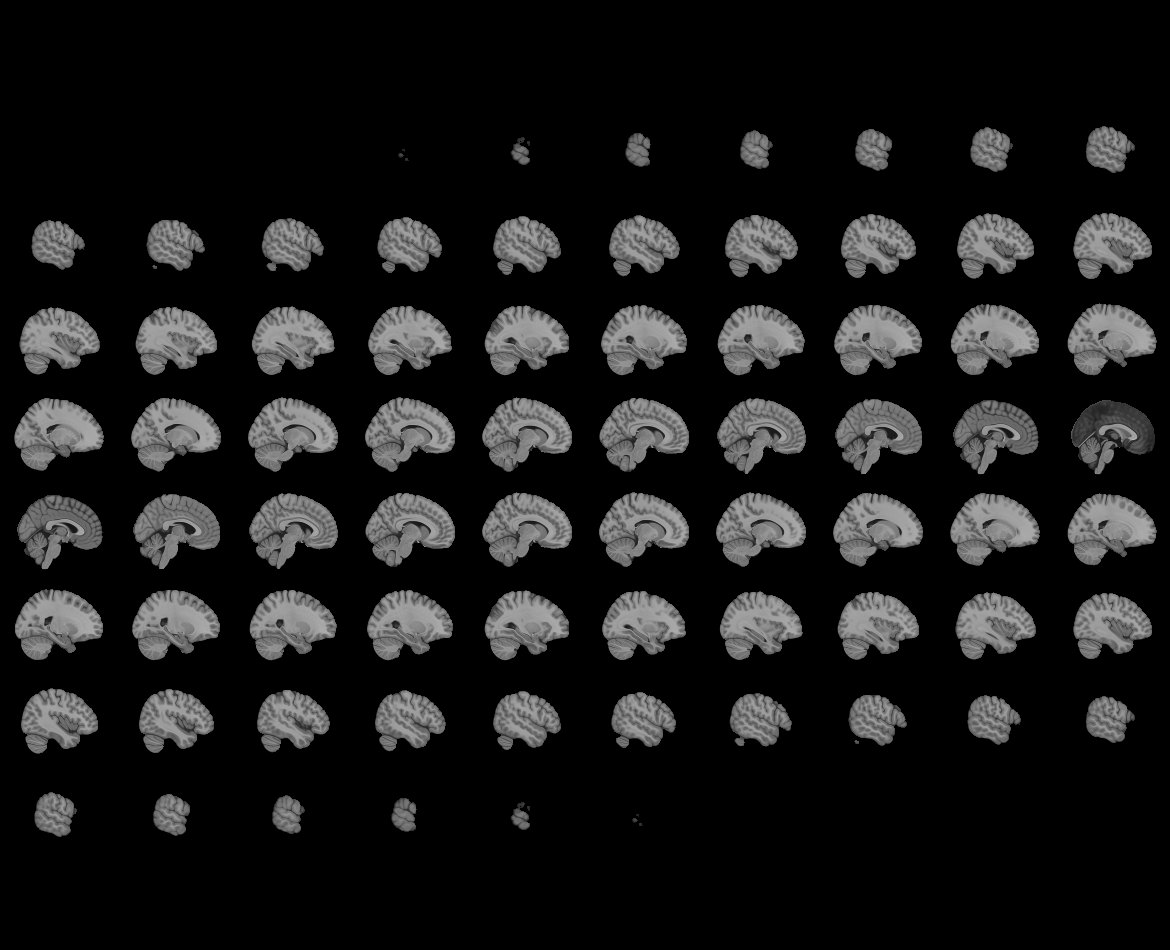
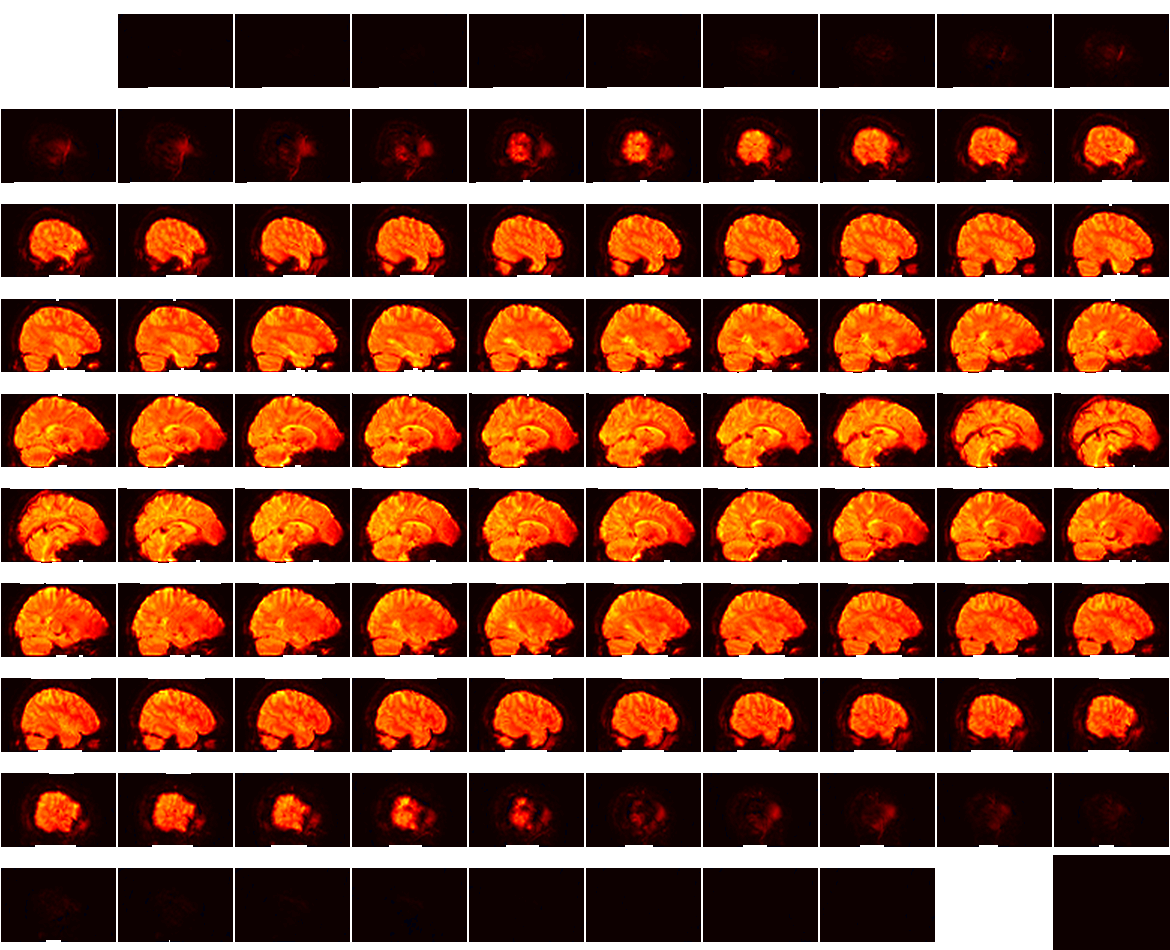

In [91]:
# Plot Average 3D Volume
plotting.view_img(mean_img, title = "Average 3D Volumes")

In [92]:
# extract 4D array  out of the restin-state image using nilearn
volumeint = nilearn.image.get_data('resting.nii.gz')

In [93]:
# check the dimension of the data 
print(volumeint.shape)

(65, 77, 60, 480)


### Extract a 2D horizontal slice from the resting-state volume

In [94]:
flat_slice = volumeint[:,:,30,0]
# check the size
print("2D slice shape :", flat_slice.shape)

2D slice shape : (65, 77)


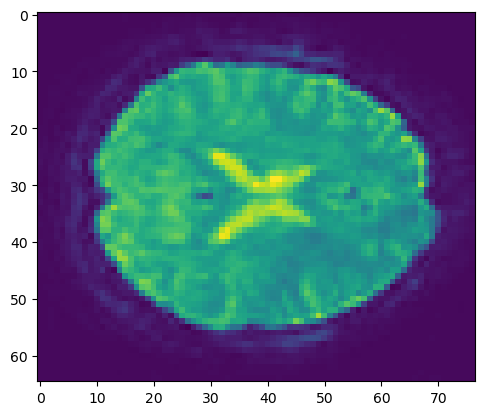

In [95]:
# display the slice
plt.imshow(flat_slice)

In [96]:
# extract the time serie for one voxel 
# select the voxel's coordinates :
x,y,z = -16, 54, 12
time_serie = volumeint[x,y,z,:]
print(time_serie)

[ 9464.396   9189.597   9395.121   9193.885   9307.554   9404.502
  9483.107   9656.065   9728.754   9303.56    9456.692   9494.282
  9378.526   9208.623   9261.649   9184.68    9168.636   9261.917
  9361.735   9518.206   9188.929   8976.268   9153.817   9170.221
  9237.385   9037.112   8957.543   9085.197   9205.216   8889.481
  9216.379   9103.608   8811.035   8922.655   9127.157   8937.069
  8687.606   8867.383   9039.902   8859.858   9101.798   8754.923
  8882.444   8872.992   9106.611   9106.295   8807.003   8917.381
  8953.201   8916.182   8790.954   8893.052   8892.1875  8700.636
  8655.018   9025.719   9086.067   8924.622   8974.815   8993.379
  8839.082   8957.54    8829.06    9094.045   8915.575   8949.55
  9040.044   9153.812   8858.384   8661.347   9000.777   8988.563
  8801.291   8913.264   9278.295   8954.72    8899.984   9073.072
  9034.234   9039.422   9138.554   9152.977   9155.686   8882.522
  8839.253   8685.892   8554.41    8548.081   8965.773   8842.056
  8692.152 

In [97]:
# make a time-vector of slice times in [s]  
# Enter the Reptition-time (RT) :
dt = 0.75
# Calculate the number of slices
num_slices = volumeint.shape[-1]
# Create a time-vector
time_vec = np.arange(num_slices)*dt
print(time_vec)


[  0.     0.75   1.5    2.25   3.     3.75   4.5    5.25   6.     6.75
   7.5    8.25   9.     9.75  10.5   11.25  12.    12.75  13.5   14.25
  15.    15.75  16.5   17.25  18.    18.75  19.5   20.25  21.    21.75
  22.5   23.25  24.    24.75  25.5   26.25  27.    27.75  28.5   29.25
  30.    30.75  31.5   32.25  33.    33.75  34.5   35.25  36.    36.75
  37.5   38.25  39.    39.75  40.5   41.25  42.    42.75  43.5   44.25
  45.    45.75  46.5   47.25  48.    48.75  49.5   50.25  51.    51.75
  52.5   53.25  54.    54.75  55.5   56.25  57.    57.75  58.5   59.25
  60.    60.75  61.5   62.25  63.    63.75  64.5   65.25  66.    66.75
  67.5   68.25  69.    69.75  70.5   71.25  72.    72.75  73.5   74.25
  75.    75.75  76.5   77.25  78.    78.75  79.5   80.25  81.    81.75
  82.5   83.25  84.    84.75  85.5   86.25  87.    87.75  88.5   89.25
  90.    90.75  91.5   92.25  93.    93.75  94.5   95.25  96.    96.75
  97.5   98.25  99.    99.75 100.5  101.25 102.   102.75 103.5  104.25
 105. 

### Plot the normalized time-serie for the selected voxel

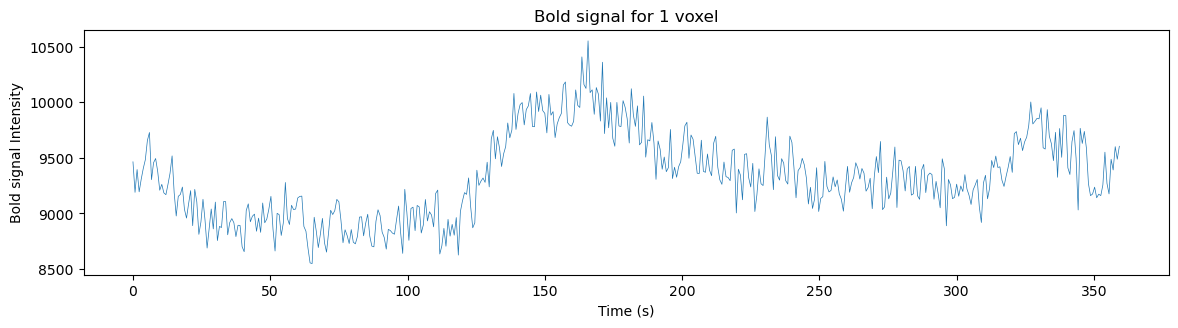

In [98]:
plt.figure(figsize=(14,7))
ax1=plt.subplot(211)
plt.plot(time_vec, time_serie, label='bold signal at'+np.array2string(np.array([30,35,30])), linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Bold signal Intensity')
plt.title('Bold signal for 1 voxel')
plt.show()
 

# Extract the segmentation mask image

## Filter the selected subject's resting-state images

In [99]:
# Display dataframe of all the "nii.gz" files
bold_task = np.array([x.endswith("nii.gz") for x in task_list])
bold_files = np.asarray(task_list)[bold_task]
pd.bold_files = pd.DataFrame([y.split('_') for y in pd.DataFrame([x.split("/") for x in bold_files])[5]])
print(pd.bold_files)

          0                  1        2                          3  \
0  sub-0001  task-restingstate  acq-mb3  space-MNI152NLin2009cAsym   
1  sub-0001  task-restingstate  acq-mb3  space-MNI152NLin2009cAsym   
2  sub-0001  task-restingstate  acq-mb3  space-MNI152NLin2009cAsym   
3  sub-0001  task-restingstate  acq-mb3  space-MNI152NLin2009cAsym   
4  sub-0001  task-restingstate  acq-mb3  space-MNI152NLin2009cAsym   
5  sub-0001  task-restingstate  acq-mb3                  space-T1w   
6  sub-0001  task-restingstate  acq-mb3                  space-T1w   
7  sub-0001  task-restingstate  acq-mb3                  space-T1w   
8  sub-0001  task-restingstate  acq-mb3                  space-T1w   
9  sub-0001  task-restingstate  acq-mb3                  space-T1w   

                4            5  
0  boldref.nii.gz         None  
1  desc-aparcaseg  dseg.nii.gz  
2       desc-aseg  dseg.nii.gz  
3      desc-brain  mask.nii.gz  
4    desc-preproc  bold.nii.gz  
5  boldref.nii.gz         None 

In [100]:
# Select the mask of regions image
file_key = bold_files[2]
print(file_key)

ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-aseg_dseg.nii.gz


## Download the proper mask image

In [101]:
# Use the boto3 client to download the file
# Save it to  my.nii_seg.nii.gz
final_name = 'resting.nii.gz'
bucket_name = 'openneuro.org'
final_name = 'my.nii_seg.nii.gz'

client.download_file(Bucket=bucket_name, Key=file_key, Filename= final_name)

In [102]:
# read  image my.nii_seg.nii.gz with nilear image library
img_seg = image.load_img(final_name)
# check and print the dimension of the data
print("Image dimensions :", img_seg.shape)

Image dimensions : (65, 77, 60)


## Visualize the mask image

C:\Users\elisa\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



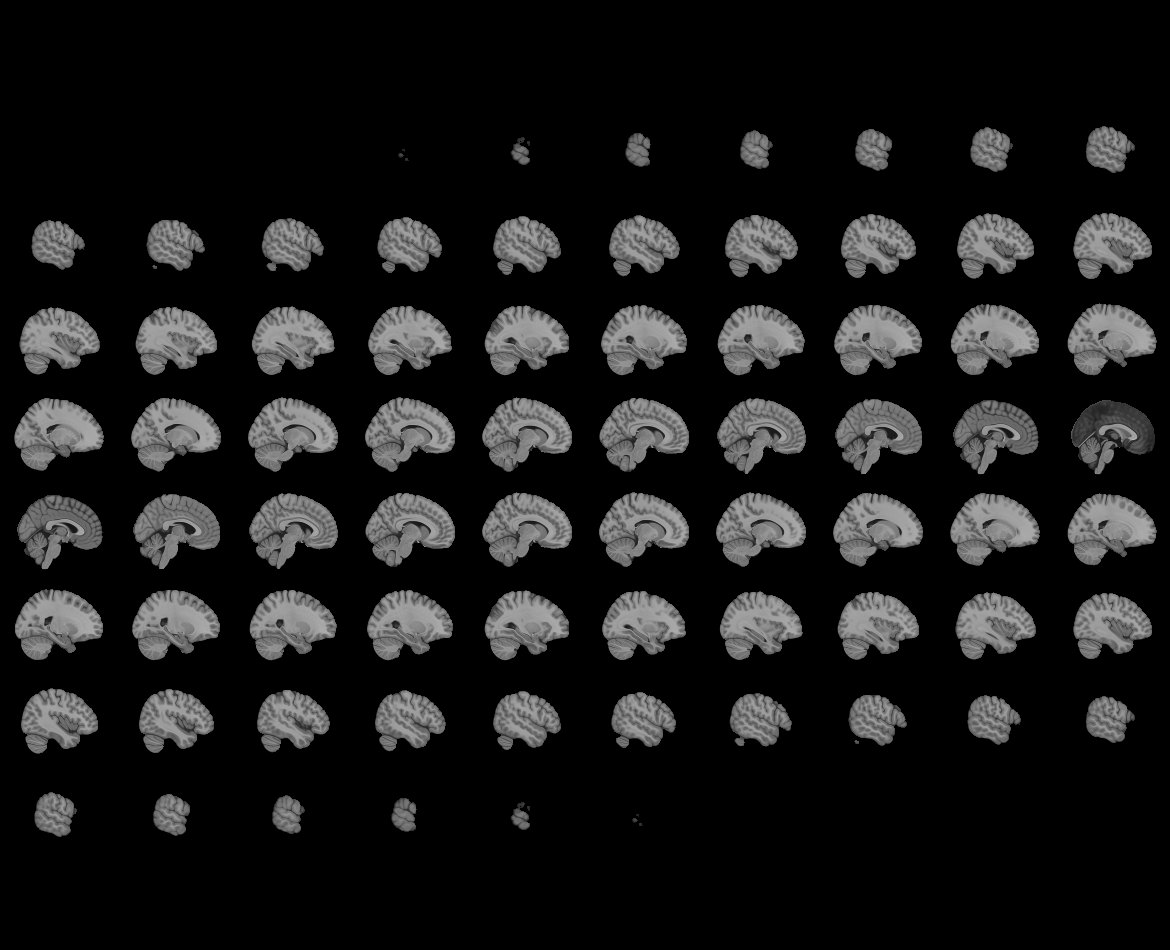
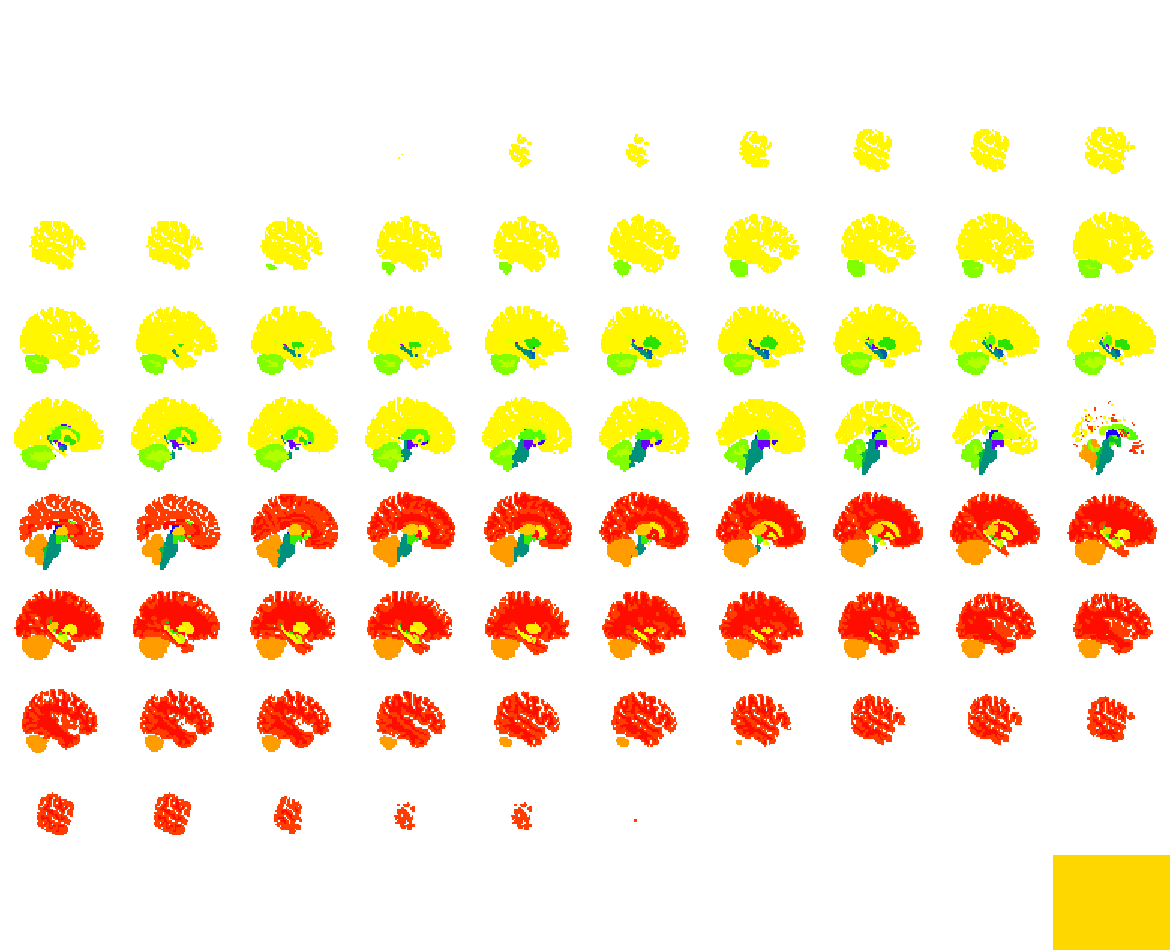

In [103]:
#  Plot the regions of interest
plotting.view_img(img_seg, threshold=1,
                  cmap=plt.cm.prism,
                  resampling_interpolation="nearest")

## Create a mask containing only the voxels of the selected Region Of Interest (ROI)

In [104]:
# extract the segmentation volume in a np.array 
seg_volume = nilearn.image.get_data(final_name)
# check the size
print(seg_volume.shape)
img_segbool=np.array(seg_volume)
print(np.sum(img_segbool))

(65, 77, 60)
1322957.0


In [105]:
# find the voxels of the region numbered 10 (left hemisphere cortex)
region_number = 3 
mask1 = np.where(np.array(seg_volume) == region_number)
print("mask1 : ",mask1)
# set all background to 0
img_segbool [:] = 0

# set the voxels from the mask to 1
img_segbool[mask1[0],mask1[1],mask1[2]] = 1

# find the voxels of the region numbered 42 (right hemisphere cortex)

region_number = 42
mask2 = np.where(np.array(seg_volume) == region_number)
print("mask2 : ",mask2)
#  and set the voxels from the mask to 1
img_segbool[mask2[0],mask2[1],mask2[2]] = 1

mask1 :  (array([ 8,  8,  9, ..., 32, 32, 32], dtype=int64), array([31, 33, 27, ..., 46, 46, 47], dtype=int64), array([21, 23, 23, ..., 35, 36, 35], dtype=int64))
mask2 :  (array([32, 32, 32, ..., 56, 56, 56], dtype=int64), array([13, 14, 15, ..., 32, 33, 33], dtype=int64), array([20, 20, 19, ..., 23, 22, 23], dtype=int64))


In [106]:
# check image dimensions
img_segbool.shape

(65, 77, 60)

In [107]:
# check the number of voxels in the region
nbr_voxel= np.sum(img_segbool)
print("Number of voxel :",nbr_voxel)

Number of voxel : 23518.0


C:\Users\elisa\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



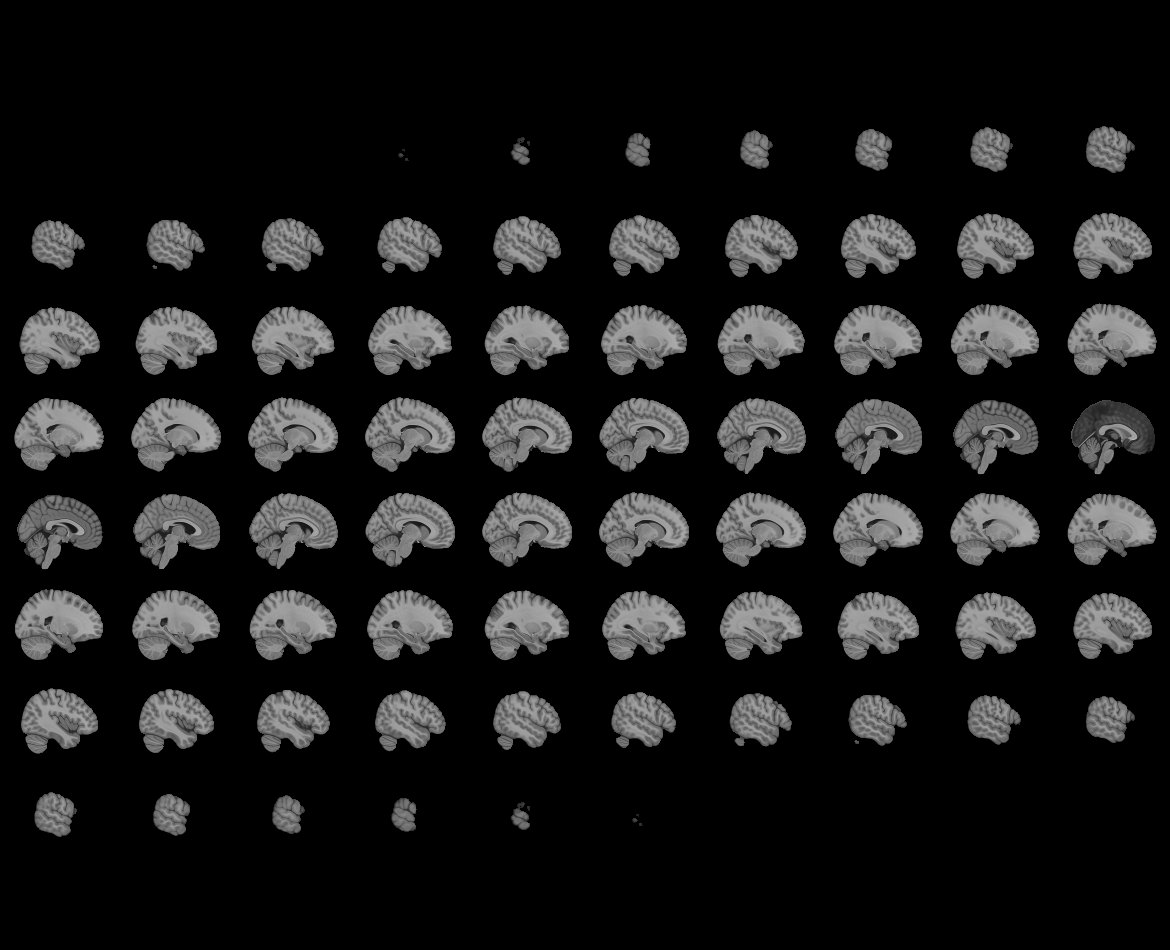
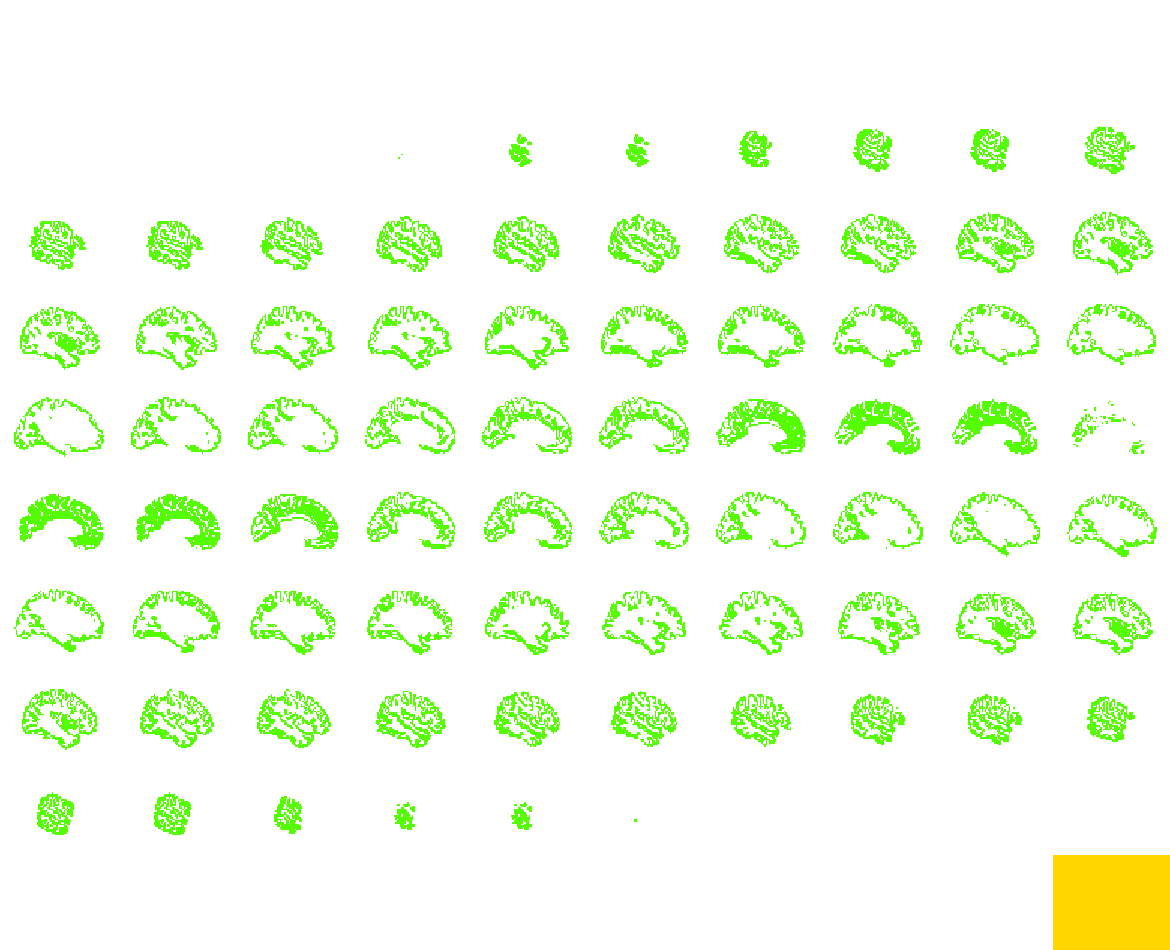

In [108]:
#  generate a nii volume from img_segbool 
nii_img_seg=nb.Nifti1Image(img_segbool,affine=img_seg.affine)
plotting.view_img(nii_img_seg,
                  cmap=plt.cm.prism,
                  resampling_interpolation="nearest")

## Apply the ROI mask to the subject's resting-state BOLD signal image

In [109]:
# use apply_mask to retreive the timeseries of the selected region, using the original resting-state nii volume img and the region volume nii_img_seg
masked_data = apply_mask(imgs=img, mask_img = nii_img_seg)
masked_data.shape

(480, 23518)

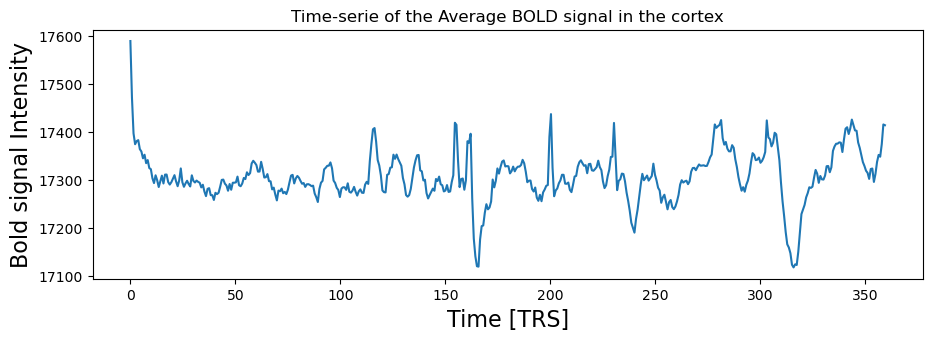

In [110]:
# plot the time-serie for the average BOLD signal across all the ROI's voxels
ROI = np.mean(masked_data, axis = 1)
plt.figure(figsize=(10, 3))
plt.plot(time_vec, ROI)
plt.xlabel('Time [TRS]', fontsize=16)
plt.ylabel('Bold signal Intensity', fontsize=16)
plt.title("Time-serie of the Average BOLD signal in the cortex")
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top =.95, right=.95, left=.12)
plt.show()

# Filtering the signal for one voxel

In [111]:
# select the time-serie of one voxel in the brain
# define the selected voxel's coordinates
x,y,z = -48, 34,-16
ts = volumeint[x,y,z,:]
print(ts)

[17299.855  17010.9    17242.586  16869.63   17136.29   17358.78
 16988.111  17400.324  17077.355  17103.896  17210.562  17226.041
 17230.059  17137.705  16926.762  17170.127  17502.754  17312.61
 16998.748  17135.09   17424.746  16926.834  17217.744  17071.283
 16978.625  16839.326  17097.38   17372.725  17140.775  16602.986
 16862.844  17066.035  17303.4    17291.805  17039.736  17022.645
 17435.684  17138.154  17523.523  16976.09   16963.805  17045.781
 17290.979  17317.037  17455.36   17037.307  17038.32   16994.363
 17331.344  16974.783  17390.674  17178.584  17245.363  17149.426
 17314.775  17207.584  17107.385  17110.18   17008.107  17045.18
 16891.922  16974.46   17287.012  17541.168  17193.217  17391.28
 17233.764  16999.78   16985.967  17087.568  16979.605  16895.318
 17037.105  16847.29   16891.848  16762.629  16831.734  16972.459
 16980.932  16716.766  16985.967  17164.447  16842.701  16855.96
 16760.453  17178.475  17185.771  17101.266  17101.645  17075.117
 16810.357  169

In [112]:
# generate a time vector for the voxel's time-serie
dt = 0.75
num_slices = volumeint.shape[-1]
time_vec = np.arange(num_slices)*dt
print(time_vec)

[  0.     0.75   1.5    2.25   3.     3.75   4.5    5.25   6.     6.75
   7.5    8.25   9.     9.75  10.5   11.25  12.    12.75  13.5   14.25
  15.    15.75  16.5   17.25  18.    18.75  19.5   20.25  21.    21.75
  22.5   23.25  24.    24.75  25.5   26.25  27.    27.75  28.5   29.25
  30.    30.75  31.5   32.25  33.    33.75  34.5   35.25  36.    36.75
  37.5   38.25  39.    39.75  40.5   41.25  42.    42.75  43.5   44.25
  45.    45.75  46.5   47.25  48.    48.75  49.5   50.25  51.    51.75
  52.5   53.25  54.    54.75  55.5   56.25  57.    57.75  58.5   59.25
  60.    60.75  61.5   62.25  63.    63.75  64.5   65.25  66.    66.75
  67.5   68.25  69.    69.75  70.5   71.25  72.    72.75  73.5   74.25
  75.    75.75  76.5   77.25  78.    78.75  79.5   80.25  81.    81.75
  82.5   83.25  84.    84.75  85.5   86.25  87.    87.75  88.5   89.25
  90.    90.75  91.5   92.25  93.    93.75  94.5   95.25  96.    96.75
  97.5   98.25  99.    99.75 100.5  101.25 102.   102.75 103.5  104.25
 105. 

## Remove complex signal drift

In [113]:
#define function for removing drift of signal:
def remove_drift(time_vec, ts):
    drift = np.poly1d(np.polyfit(time_vec, ts, 4))(time_vec)
    fitted_ts = ts - drift
    return drift, fitted_ts

### Visualizing the signal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


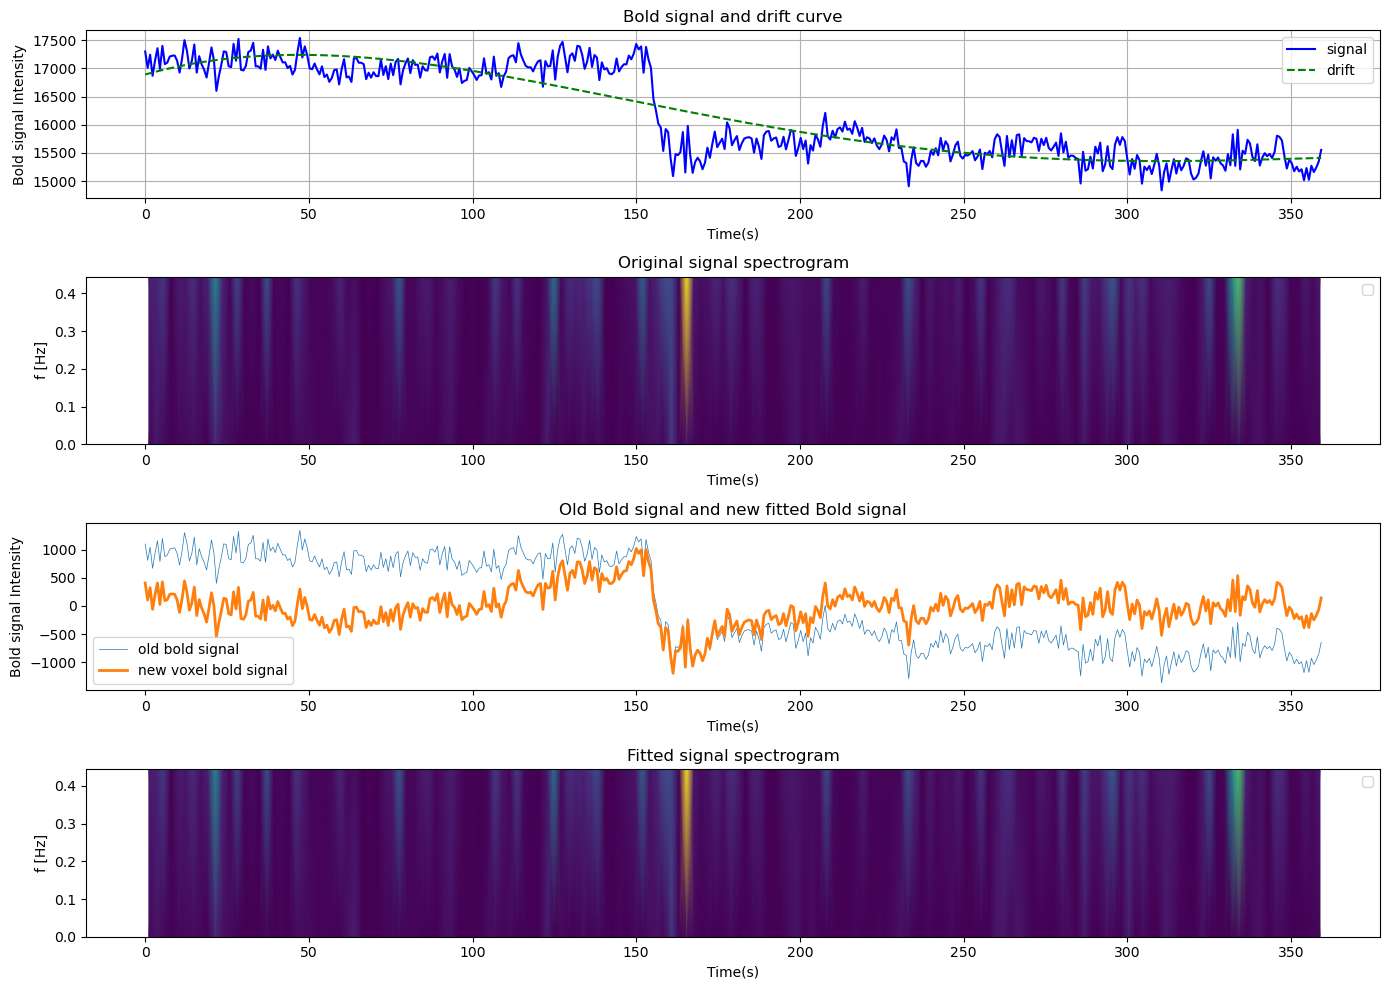

In [114]:
# plot the signal and the fitted drift
drift, fitted_ts = remove_drift(time_vec, ts)
t = time_vec
y=ts
plt.figure(figsize=(14,10))
ax2=plt.subplot(411)
plt.plot(t, y, 'b-', label='signal')
plt.plot(t,drift, 'g--', label='drift')
plt.xlabel('Time(s)')
plt.ylabel('Bold signal Intensity')
plt.title('Bold signal and drift curve')
plt.legend()
plt.grid()

# plot  sprectrogram of the original signal 
freqs, times, spectro = spectrogram( y,fs=1/dt, nperseg=3)
plt.subplot(412, sharex=ax2)
plt.pcolormesh(times, fftshift(freqs), fftshift(spectro, axes=0), shading='gouraud')
plt.xlabel('Time(s)')
plt.ylabel('f [Hz]')
plt.title('Original signal spectrogram')
plt.legend()
plt.subplot(413, sharex=ax2)

# plot old and new fitted BOLD signal for the selected voxel (centerd on the mean)
plt.plot(np.array(range(0,len(ts)))*dt, y-y.mean(), label='old bold signal', linewidth=0.5)
plt.plot(np.array(range(0,len(ts)))*dt, fitted_ts-fitted_ts.mean(), label='new voxel bold signal', linewidth=2)
plt.xlabel('Time(s)')
plt.ylabel('Bold signal Intensity')
plt.title("Old Bold signal and new fitted Bold signal")
plt.legend()

# plot the sprectrogram for new fitted signal 
freqs, times, spectro = spectrogram( fitted_ts,fs=1/dt, nperseg=3)
plt.subplot(414, sharex=ax2)
plt.pcolormesh(times, fftshift(freqs), fftshift(spectro, axes=0), shading='gouraud')
plt.ylabel('f [Hz]')
plt.xlabel('Time(s)')
plt.title('Fitted signal spectrogram')

plt.legend()

# Auto space
plt.tight_layout()

# Display plot
plt.show()


## Visualize  FFT

Text(0.5, 1.0, 'FFT frequency components')

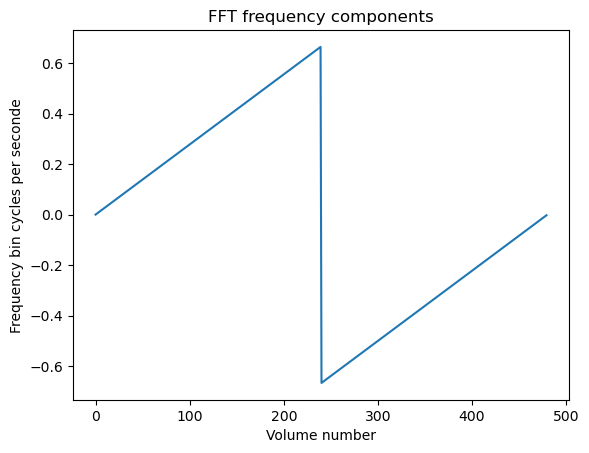

In [115]:
# calculate the FFT of the original signal and plot the frequency components 
rate = 1/dt
fft_result = np.fft.fft(fitted_ts)
fft_freq = np.fft.fftfreq(len(fitted_ts), dt)
plt.plot(fft_freq)
plt.xlabel('Volume number')
plt.ylabel('Frequency bin cycles per seconde')
plt.title('FFT frequency components')

## Create a High-pass filter

### Make a high pass filter function


In [116]:
def high_pass_filter(signal) :
    # Make a high pass filter  
    b, a = scipy.signal.butter(5, 0.01, 'high', fs=rate)
    # apply the filter to the signal obtained after drift removal
    filtered_freq = scipy.signal.filtfilt(b, a, signal)
    return b, a, filtered_freq
    



### Visualize the filtered signal

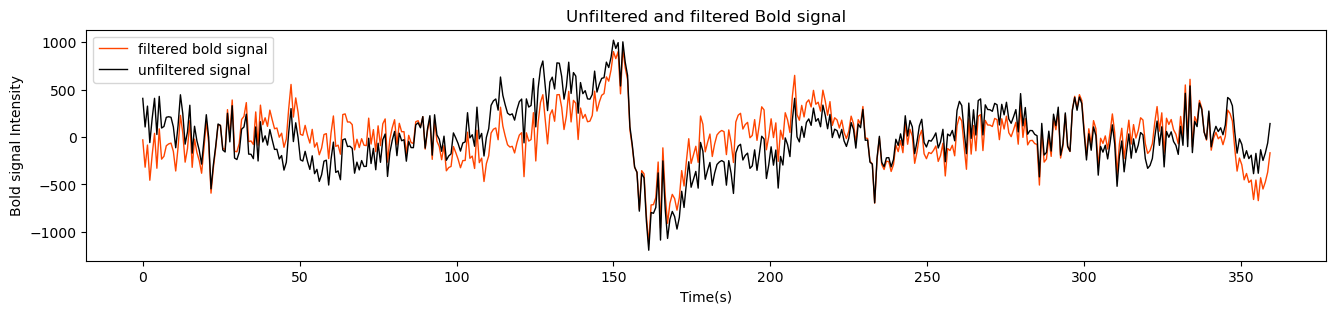

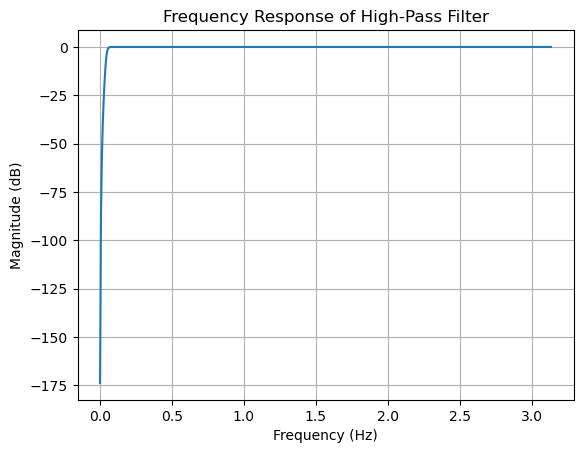

In [117]:
# Create a filtered signal with the high pass filter function :
b, a, filtered_freq = high_pass_filter(fitted_ts)

# plot both the original and filtered signals
plt.figure(figsize=(16,3))
plt.plot(np.array(range(0,len(ts)))*dt, filtered_freq-filtered_freq.mean(), label='filtered bold signal', linewidth=1, color = "orangered")
plt.plot(np.array(range(0,len(ts)))*dt, fitted_ts-fitted_ts.mean(), label='unfiltered signal', linewidth=1, color = "k")
plt.xlabel('Time(s)')
plt.ylabel('Bold signal Intensity')
plt.title('Unfiltered and filtered Bold signal')
plt.legend()

# Calculate the frequency response
w, h = freqz(b, a)
db = 20 * np.log10(abs(h))

# Plot the frequency response
plt.figure()
plt.plot(w, db)
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('Frequency Response of High-Pass Filter')
plt.grid(which='both', axis='both')
plt.show()

## Visualize FFT

Text(0.5, 1.0, 'FFT frequency components')

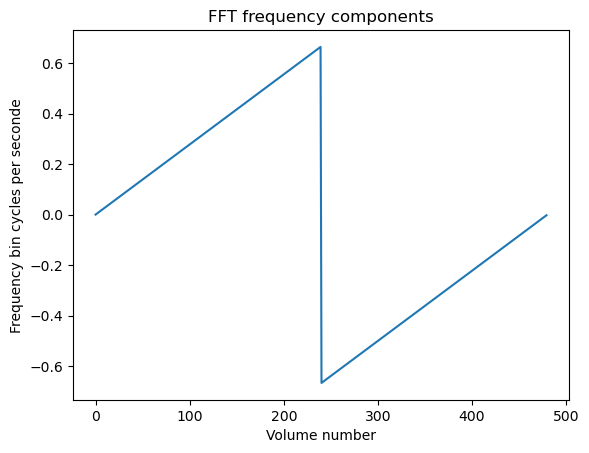

In [118]:
# calculate the FFT of the filtered signal
fft_filtered = np.fft.fft(filtered_freq)
fft_freq = np.fft.fftfreq(filtered_freq.size, dt)
plt.plot(fft_freq)
plt.xlabel('Volume number')
plt.ylabel('Frequency bin cycles per seconde')
plt.title('FFT frequency components')

## Visualize the spectrograms before and after high-pass filtering

### Before high-pass filtering

Text(0.5, 1.0, 'Unfiltered signal spectrogram')

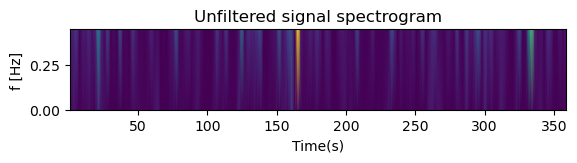

In [119]:
# plot the spectrogram of the signal before filtering
freqs, times, spectro = spectrogram( fitted_ts,fs=1/dt, nperseg=3)
plt.subplot(412)
plt.pcolormesh(times, fftshift(freqs), fftshift(spectro, axes=0), shading='gouraud')
plt.xlabel('Time(s)')
plt.ylabel('f [Hz]')
plt.title('Unfiltered signal spectrogram')

### After high-pass filtering

Text(0.5, 1.0, 'High-pass filtered signal spectrogram')

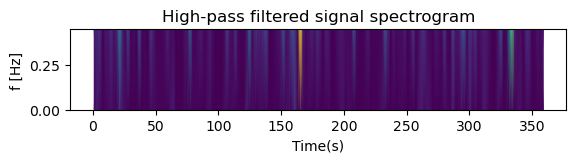

In [120]:
 # plot the spectrogram of the signal after high-pass filtering
freqs, times, spectro = spectrogram( filtered_freq,fs=1/dt, nperseg=3)
plt.subplot(412, sharex=ax2)
plt.pcolormesh(times, fftshift(freqs), fftshift(spectro, axes=0), shading='gouraud')
plt.xlabel('Time(s)')
plt.ylabel('f [Hz]')
plt.title('High-pass filtered signal spectrogram')

# Create a Low-pass filter

### Make a Low-pass filter function

In [121]:
def low_pass_filter(signal):
    # Make a low-pass filter 
    b, a = scipy.signal.butter(5, 0.15, 'low', fs=rate)
    # apply the filter to the signal (obtained after drift removal and high-pass filtering)
    final_filtered_signal = scipy.signal.filtfilt(b, a, signal)
    return b, a, final_filtered_signal

### Visualize the filter's frequency response

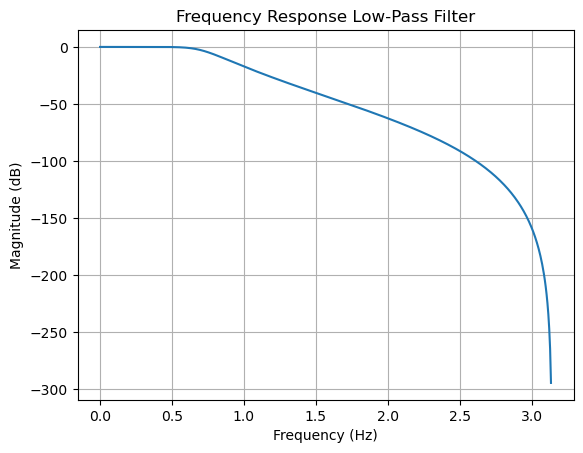

In [122]:
b, a, final_filtered_signal = low_pass_filter(filtered_freq)
# Calculate the frequency response
w, h = freqz(b, a)
db = 20 * np.log10(abs(h))
# Plot the frequency response
plt.figure()
plt.plot(w, db)
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('Frequency Response Low-Pass Filter')
plt.grid(which='both', axis='both')
plt.show()

## Visualize the final signal

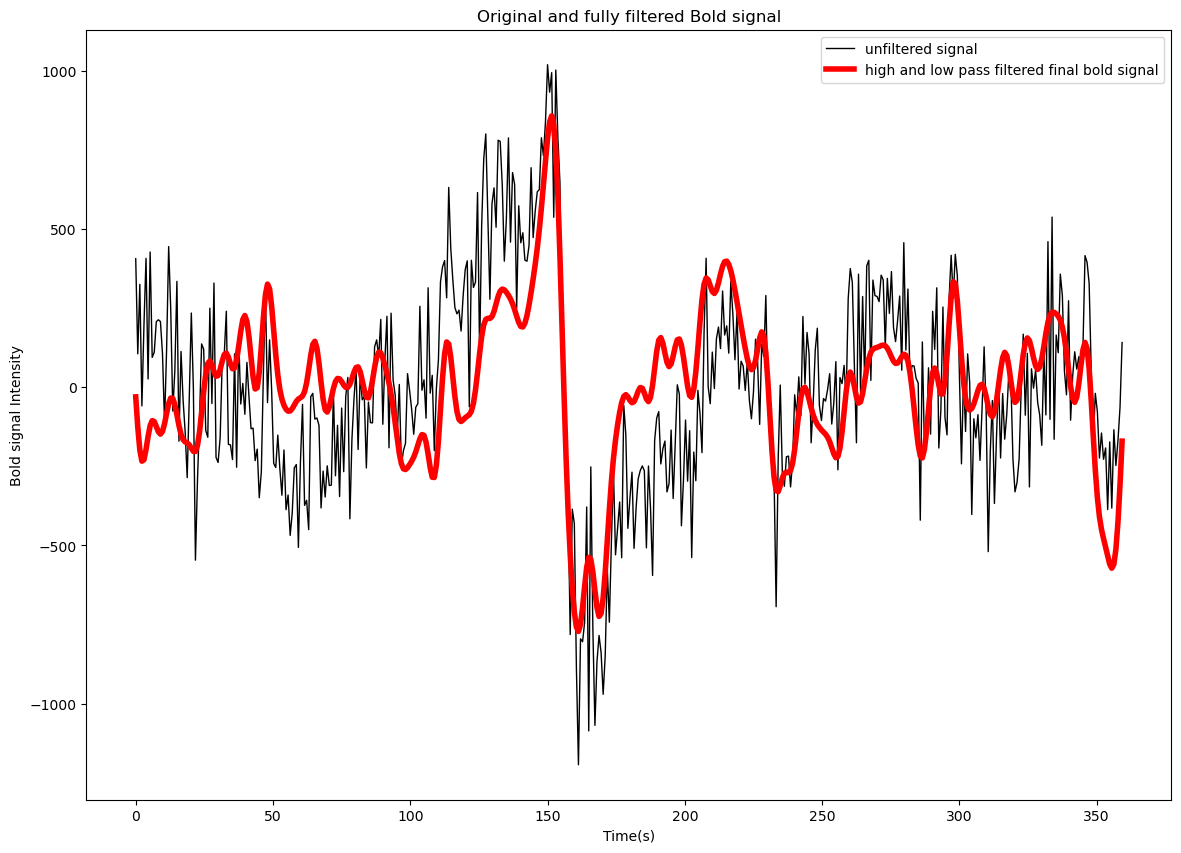

In [123]:
# plot the original, high pass filtered and fully-filtered signals
plt.figure(figsize=(14,10))
plt.plot(np.array(range(0,len(ts)))*dt, fitted_ts-fitted_ts.mean(), label='unfiltered signal', linewidth=1, color = "k")
plt.plot(np.array(range(0,len(ts)))*dt, final_filtered_signal-final_filtered_signal.mean(), label='high and low pass filtered final bold signal', linewidth=4, color = "r")

plt.xlabel('Time(s)')
plt.ylabel('Bold signal Intensity')
plt.title('Original and fully filtered Bold signal')
plt.legend()

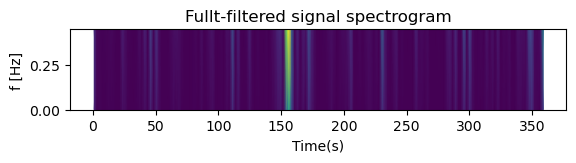

In [124]:
# Plot the spectogram of the fully-filtered final signal
freqs, times, spectro = spectrogram( final_filtered_signal,fs=1/dt, nperseg=3)
plt.subplot(412, sharex=ax2)
plt.pcolormesh(times, fftshift(freqs), fftshift(spectro, axes=0), shading='gouraud')
plt.xlabel('Time(s)')
plt.ylabel('f [Hz]')
plt.title('Fullt-filtered signal spectrogram')
plt.show()


# Correlation of the time-series of 2 ROIs (cross-region analysis)

## Extract your first selected ROI (Left thalamus)

### Generate the mask of the first ROI 

In [125]:
# find the mask voxels corresponding to the region numbered 10 (left thalamus)
region_number = 10
mask_thal = np.where(np.array(seg_volume) == region_number)
print("mask thalamus : ",mask_thal)
# set all background to 0
img_segbool [:] = 0

# set the voxels from the mask to 1
img_segbool[mask_thal[0],mask_thal[1],mask_thal[2]] = 1



mask thalamus :  (array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       

C:\Users\elisa\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\elisa\anaconda3\Lib\site-packages\nilearn\plotting\html_document.py:65: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



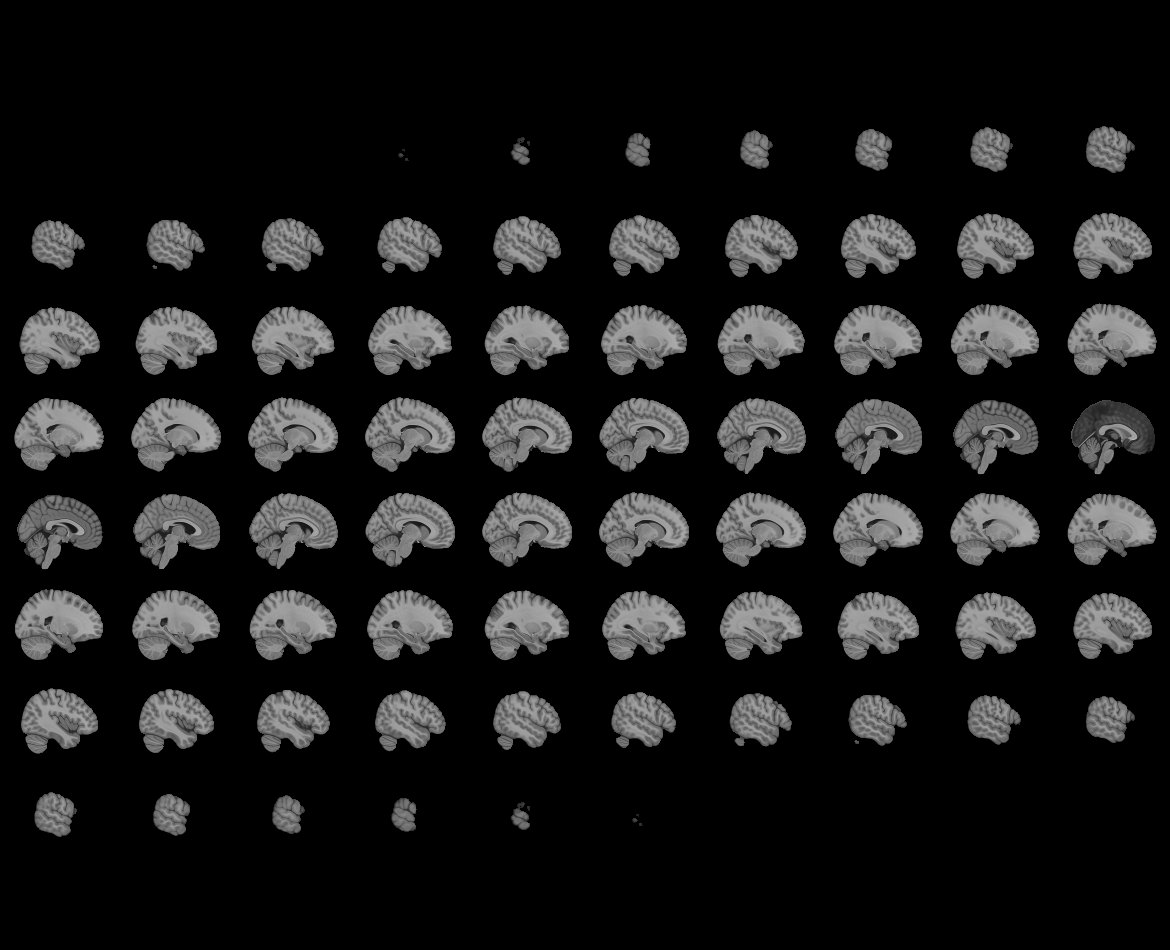
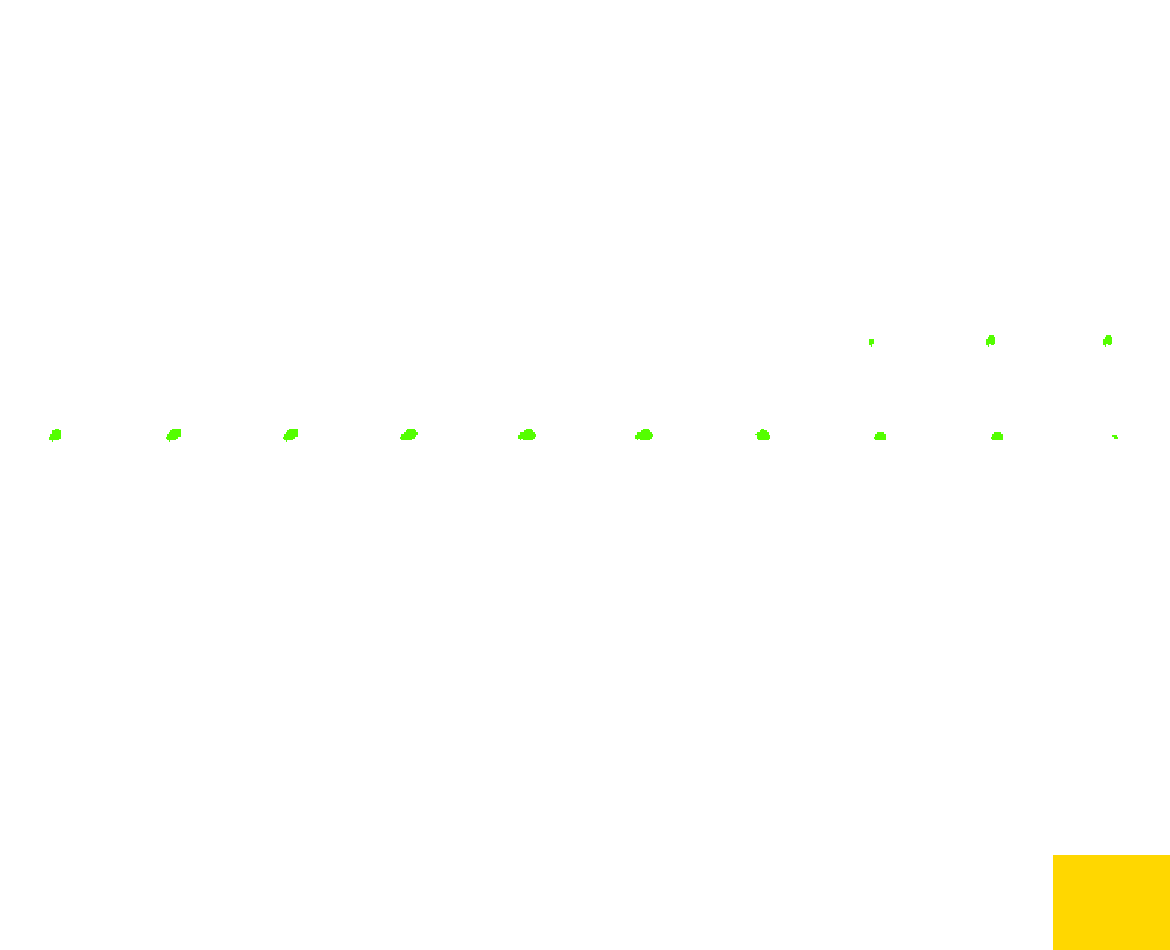

In [126]:
#  create a nii volume from our mask region using  Nifti1Image function and the original img_seg volume 
nii_mask_ROI1 =nb.Nifti1Image(img_segbool,affine=img_seg.affine)
plotting.view_img(nii_mask_ROI1,
                  cmap=plt.cm.prism,
                  resampling_interpolation="nearest")

### Apply the mask of the first ROI to the subject's resting-state Bold signal image

In [127]:
# use apply_mask to retreive the timeseries of the selected region (ROI) using the original nii volume img and the region volume nii_mask_ROI1
masked_dataROI1 = apply_mask(imgs=img, mask_img = nii_mask_ROI1)
# check the shape
masked_dataROI1.shape

(480, 352)

### Visualize the ROI's time-serie

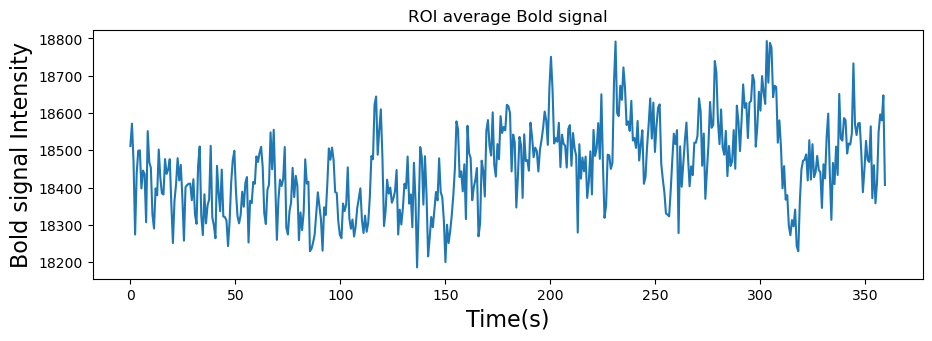

In [128]:
# generate the time-serie corresponding to the mean of the BOLD signal of all the voxels composing the ROI
ROI1 = np.mean(masked_dataROI1, axis = 1)
#Plot the ROI's time-serie
plt.figure(figsize=(10, 3))
plt.plot(time_vec, ROI1)
plt.xlabel('Time(s)', fontsize=16)
plt.ylabel('Bold signal Intensity', fontsize=16)
plt.title('ROI average Bold signal')
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top =.95, right=.95, left=.12)
plt.show()

### Filter ROI1 time-serie's signal

In [129]:
# Remove the drift using drift removal function
drift, fitted_ts_ROI1 = remove_drift(time_vec, ROI1)
# Remove low frequencies using high-filter function
filtered_freq_ROI1 = high_pass_filter(fitted_ts_ROI1)[2]
# Remove high frequencies using low-pass filter function
final_signal_ROI1 = low_pass_filter(filtered_freq_ROI1)[2]


### Visualize ROI 1 (Left Thalamus)

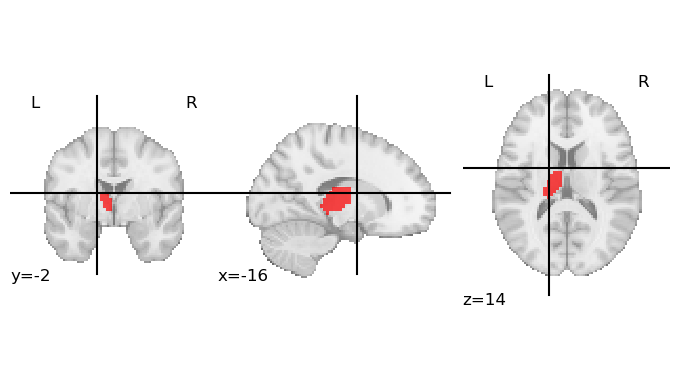

In [130]:
# Display Left Thalamus
plotting.plot_roi(nii_mask_ROI1, cut_coords = (-16, -2, 14), cmap = plt.cm.prism, resampling_interpolation = "nearest")

## Extract your second selected ROI

### Generate the mask of the second ROI (Left putamen)

In [131]:
# set all background to 0
img_segbool [:] = 0
# find the mask voxels corresponding to the region numbered 11 (left putamen)
region_number = 12
mask_putamen = np.where(np.array(seg_volume) == region_number)
print("mask putamen : ",mask_putamen)
#  and set the voxels from the mask to 1
img_segbool[mask_putamen[0],mask_putamen[1],mask_putamen[2]] = 1

mask putamen :  (array([20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26,
       2

C:\Users\elisa\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\elisa\anaconda3\Lib\site-packages\nilearn\plotting\html_document.py:65: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



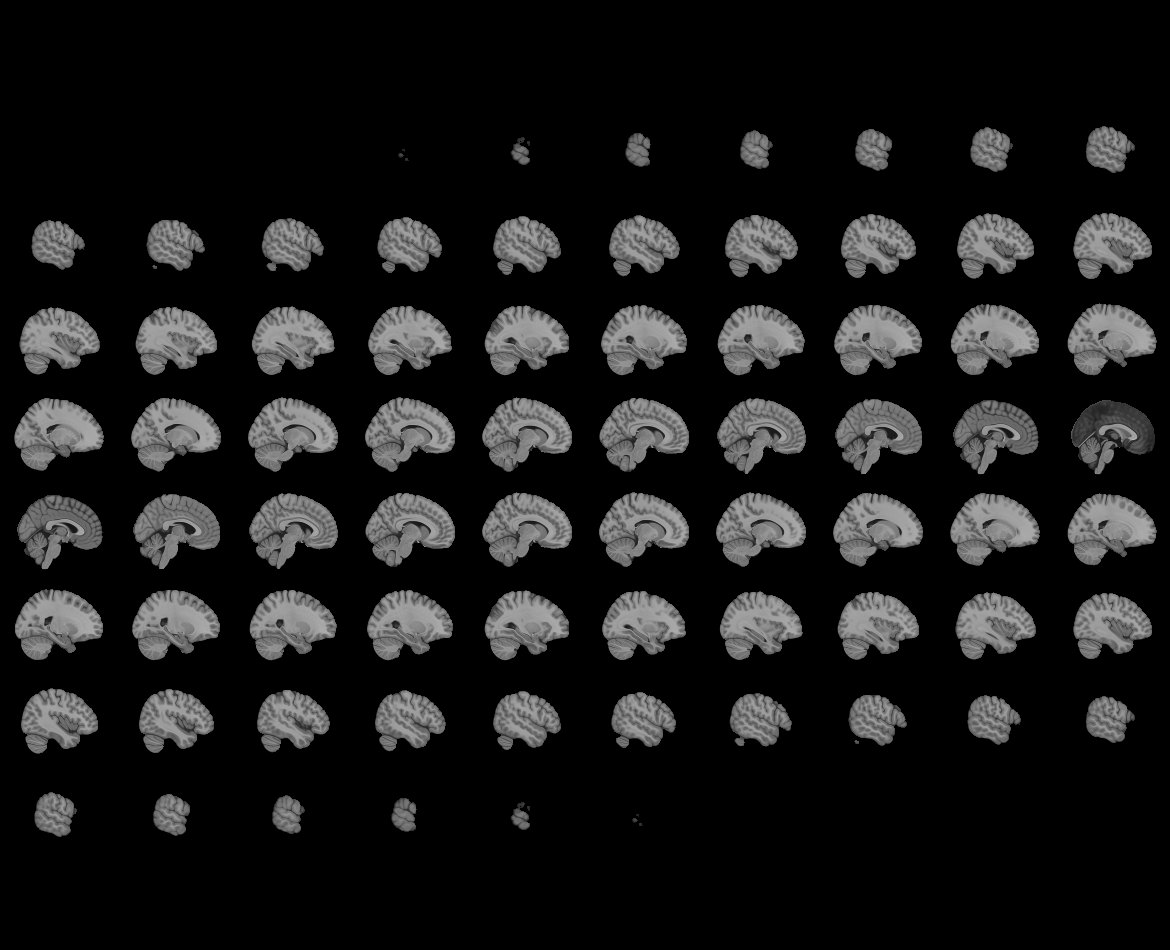
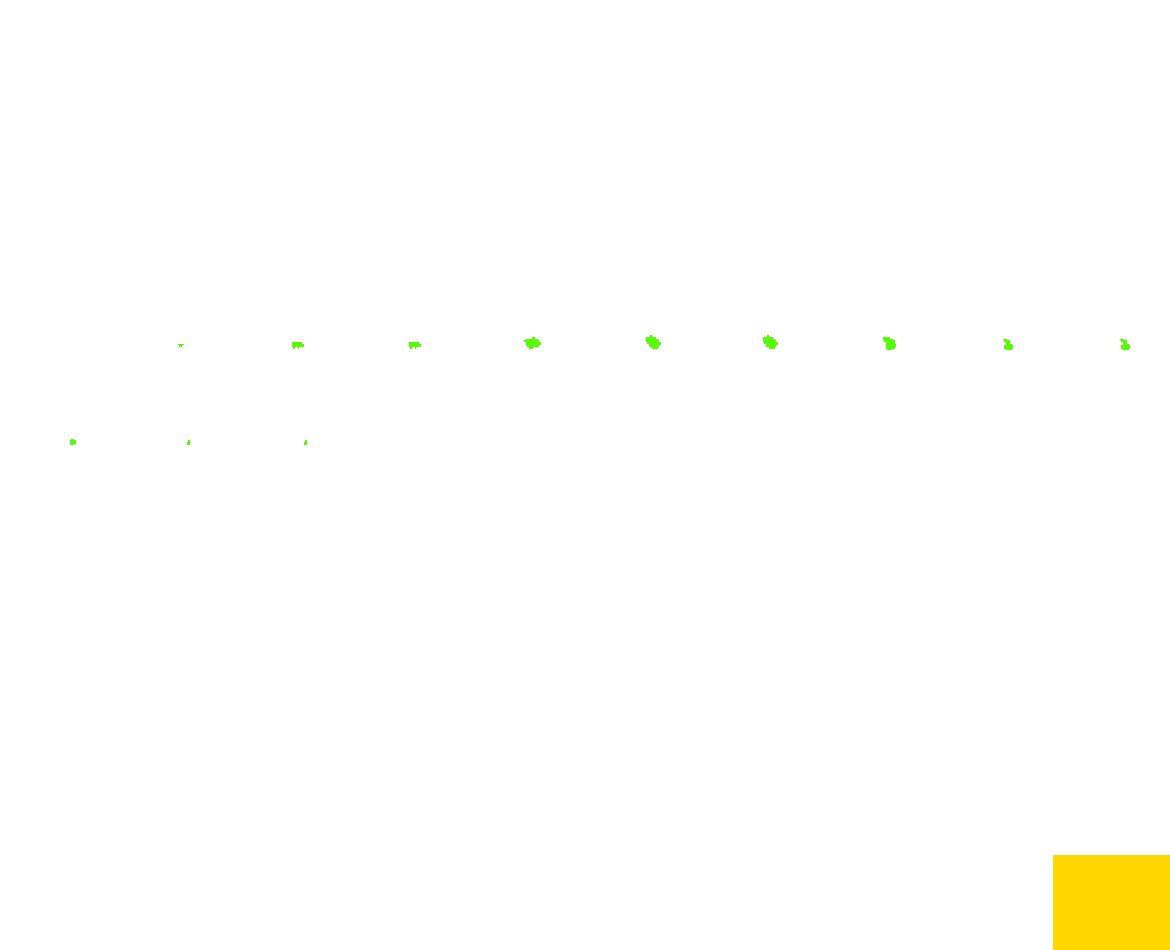

In [132]:
#  create a nii volume from our mask region using  Nifti1Image function and the original img_seg volume 
nii_mask_ROI2 =nb.Nifti1Image(img_segbool,affine=img_seg.affine)
plotting.view_img(nii_mask_ROI2,
                  cmap=plt.cm.prism,
                  resampling_interpolation="nearest")

### Apply the mask of the second ROI to the subject's resting-state Bold signal image

In [133]:
# use apply_mask to retreive the timeseries of the selected region (ROI) using the original nii volume img and the region volume nii_mask_ROI1
masked_dataROI2 = apply_mask(imgs=img, mask_img = nii_mask_ROI2)
# check the shape
masked_dataROI2.shape

(480, 231)

### Visualize the ROI's time-serie

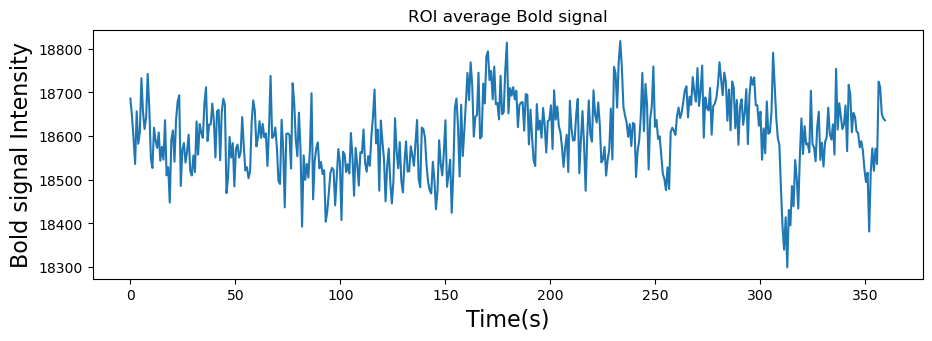

In [134]:
# generate the time-serie corresponding to the mean of the BOLD signal of all the voxels composing the ROI
ROI2 = np.mean(masked_dataROI2, axis = 1)
#Plot the ROI's time-serie
plt.figure(figsize=(10, 3))
plt.plot(time_vec, ROI2)
plt.xlabel('Time(s)', fontsize=16)
plt.ylabel('Bold signal Intensity', fontsize=16)
plt.title('ROI average Bold signal')
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top =.95, right=.95, left=.12)
plt.show()

### Filter ROI2 time-serie's signal

In [135]:
# Remove the drift using drift removal function
drift, fitted_ts_ROI2 = remove_drift(time_vec, ROI2)
# Remove low frequencies using high-filter function
filtered_freq_ROI2 = high_pass_filter(fitted_ts_ROI2)[2]
# Remove high frequencies using low-pass filter function
final_signal_ROI2 = low_pass_filter(filtered_freq_ROI2)[2]


### Visualize ROI2 (Left Putamen)


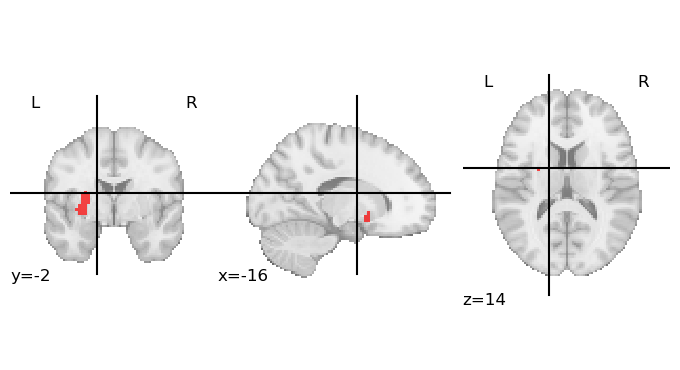

In [136]:
# Display Left Putamen
plotting.plot_roi(nii_mask_ROI2, cut_coords = (-16, -2, 14), cmap = plt.cm.prism, resampling_interpolation = "nearest")

## Visualize the filtered Bold time-serie of the 2 selected ROI's

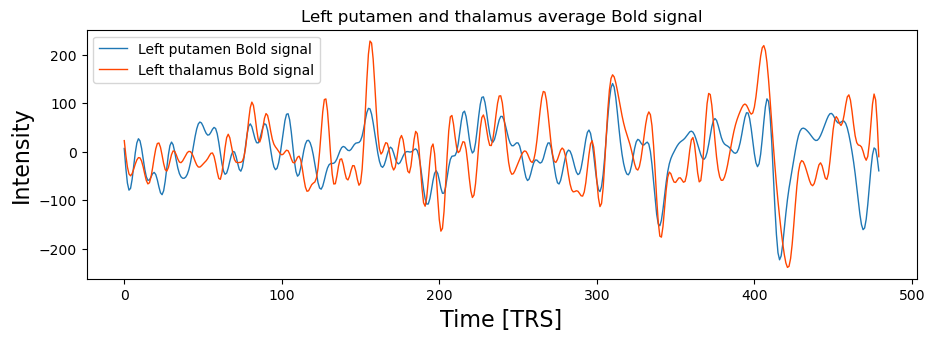

In [137]:
plt.figure(figsize=(10, 3))
# Plot the time-series of the 2 ROIs you want to compare
plt.plot(final_signal_ROI2, linewidth =1, label = 'Left putamen Bold signal')
plt.plot(final_signal_ROI1, linewidth =1, color ="orangered", label = 'Left thalamus Bold signal')
plt.xlabel('Time [TRS]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.title('Left putamen and thalamus average Bold signal')
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top =.95, right=.95, left=.12)
plt.legend()
plt.show()

## Determine de degree of correlation of the signal between the 2 ROIs

In [138]:
#corelate the two regions using Pearson correlation coefficient

mean1 = sum(final_signal_ROI1)/len(final_signal_ROI1)
mean2= sum(final_signal_ROI2)/len(final_signal_ROI2)

cov = sum((a - mean1) * (b - mean2) for (a,b) in zip(final_signal_ROI1, final_signal_ROI2)) / len(final_signal_ROI1)

stdev1 = (sum((a - mean1)**2 for a in final_signal_ROI1)/len(final_signal_ROI1))**0.5
stdev2 = (sum((b - mean2)**2 for b in final_signal_ROI2)/len(final_signal_ROI2))**0.5

result = round(cov/(stdev1*stdev2),3)
print("coeff r =", result)



if 0.5 < result <= 1:
    print("Both regions are involved in similar cognitive processes")
elif -1 <= result <= - 0.5:
    print("Cognitive processes are mutually exclusive")
else:
    print("Cognitive processes are independent")



coeff r = 0.505
Both regions are involved in similar cognitive processes
